# Neural Network

Below is my understanding and realisation of Deep NN. Knowledge and dataset taken from [deeplearning.ai course](https://www.deeplearning.ai/courses/deep-learning-specialization/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

## Model Scheme

<img src='png/nn-scheme.jpg'>

### 1. Forward Propagation

Forward Propagation has $L$ layers.

Activation functions:

- **Sigmoid**: $\displaystyle\sigma(z) = \frac{1}{1 + e^{-Z}}$ - used for last layer (prediction).

- **ReLU**: $\displaystyle relu(z) = max(0,z)$ - used for hidden layers.

Reccurent relation for computing forward propagation (superscript ~ layer's number):

$$Z^{[i]} = W^{[i]}A^{[i-1]} + b^{[i]}$$

$$A^{[i]} = a^{[i]}(Z^{[i]}), \ \ A^{[0]} = X$$

where $a^{[l]}$ is activation function of layer $l$, either ReLU or sigmoid.

### 2. Cost (MLE)

Given input vector $x$, we want to estimate probability of observing output value $y$, which is $p(y|x) = \widehat{y}$. It means that $p(y = 0|x) = \widehat{y}$ and $p(y = 1|x) = 1 - \widehat{y}$ (or vice versa). It could be shown that probability distribution $p(y|x) = \widehat{y}^y \times (1 - \widehat{y}) ^{1-y}$ is indeed a probability distribution and produces needed values for $y = 0$ and $y = 1$. Thus, maximizing $p(y|x)$ is the same as minimizing $-\log p(y|x)$, which is easier to compute. $-\log p(y|x) = - (\widehat{y}\log y + (1-\widehat{y})\log(1 - y))$.

That is, given input vector $X$ of **independently and identically distributed** random variables (which are vectors, and thus $X$ is matrix), we want to estimate probability of observing output vector $Y$, which is $p(Y|X)$.

$$p(Y|X) = \prod_{i=1}^{n} p(y_i|x_i)$$
$$-\log p(Y|X) = \sum_{i=1}^{n} \log p(y_i|x_i)$$

$$J(\widehat{Y}, Y) = - \frac{1}{n} \sum_{i=1}^{n} \widehat{y}_i\log y_i + (1-\widehat{y}_i)\log(1 - y_i)$$

### 3. Backward Propagation

<img src='png/forw-back-nn.jpg'>

Consider layer $l < L$.

It is propagated forward as: $Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}; A^{[l]} = a^{[l]}(Z^{[l]})$. Assume you have already calculated $dZ^{[l]}$ and need to get $dW^{[l]}, db^{[l]}, dA^{[l-1]}$.

$$dW^{[l]} = \frac{\partial J}{\partial W^{[l]}} = \frac{\partial J}{\partial Z^{[l]}} (\text{which is calculated on previous step}) \times \frac{\partial Z^{[l]}}{\partial W^{[l]}} = \frac{1}{n}dZ^{[l]} A^{[l-1]T}$$

$$db^{[l]} = \frac{\partial J}{\partial b^{[l]}} = \frac{\partial J}{\partial Z^{[l]}} = \frac{1}{m}\sum_{i=1}^{n} dZ^{[l](i)}$$

$$dA^{[l-1]} = \frac{\partial J}{\partial A^{[l-1]}} = \frac{\partial J}{\partial Z^{[l]}} \times \frac{\partial Z^{[l]}}{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$

Computing $dZ^{[l]}$ gives opportunity to **update weights** in current layer $l$ and continue with layer $l-1$.

$$dZ^{[l]} = \frac{\partial J}{Z^{[l]}} = \frac{\partial J}{\partial A^{[l]}} \times \frac{\partial A^{[l]}}{\partial Z^{[l]}} = dA^{[l]} \times a^{[l]'}(Z)$$

where $a^{[l]'}(Z)$ is derivative of activation function $a(Z)$ of layer $l$ with respect to $Z$. We need one for both ReLU and sigmoid:

- **ReLU**: $relu'(z) = [z > 0]$.
- **Sigmoid**: $\sigma'(z) = \sigma(z) (1 - \sigma(z))$

However, **to initialize the chain** we need to compute $dA^{[l]}$ first. For $l = L$ (check with two lines of calculus):

$$\frac{\partial  J(a^{[l](i)}, y^{(i)})}{\partial a^{[l](i)}} = - \frac{y^{(i)}}{a^{[l](i)}} + \frac{1 - y^{(i)}}{1 - a^{[l](i)}}$$

## Activation functions

In [2]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(dA, Z):
    s = sigmoid(Z)
    return dA * s * (1 - s)

In [3]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(dA, Z):
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    return dZ

## Neural Network Class

In [4]:
class nn_model:
    def __init__(self, layer_sizes=[5, 5, 5], learning_rate=0.01, n_epochs=2500, print_cost=True):
        self.learning_rate_ = learning_rate
        self.L_ = len(layer_sizes) - 1 # number of layers (except input layer)
        self.layer_sizes_ = deepcopy(layer_sizes)
        self.n_epochs_ = n_epochs
        self.print_cost = print_cost
        
        self.W_ = list()
        self.b_ = list()
        
        self.activation_f_ = {'sigmoid': sigmoid, 'relu': relu}
        self.activation_f_derivative_ = {'sigmoid': sigmoid_derivative, 'relu': relu_derivative}
        
    # Initialization
    def _initialize(self, w_coef=0.01):
        np.random.seed(1)
        
        for i in range(self.L_):
            
            shape_W = (self.layer_sizes_[i + 1], self.layer_sizes_[i])
            self.W_.append(np.random.randn(*shape_W) / np.sqrt(self.layer_sizes_[i]))
            
            shape_b = (self.layer_sizes_[i + 1], 1)
            self.b_.append(np.zeros(shape_b))
        
    # Forward propagation
    def _forward_step(self, A_prev, W, b, activation):
        Z = np.dot(W, A_prev) + b
        A = self.activation_f_[activation](Z)
        
        cache = {'Z': Z, 'A': A, 'A_prev': A_prev, 'W': W, 'b': b}
        
        return A, cache
    
    def _forward_prop(self, X):
        self.cache_ = list()
        A = X
        
        for i in range(self.L_-1):
            A_prev = A
            
            A, cache = self._forward_step(A_prev, self.W_[i], self.b_[i], 'relu')
            self.cache_.append(cache)
            
        A_last, cache = self._forward_step(A, self.W_[-1], self.b_[-1], 'sigmoid')
        self.cache_.append(cache)
        
        return A_last
    
    # Backward propagation
    def _backward_step(self, dA, cache, activation):
        derivative = self.activation_f_derivative_[activation]
        Z = cache['Z']
        
        dZ = derivative(dA, Z)
        
        A_prev, W, b = cache['A_prev'], cache['W'], cache['b']
        n_instances = A_prev.shape[1]
        
        dW = np.dot(dZ, A_prev.T) / n_instances
        db = np.sum(dZ, axis=1, keepdims=True) / n_instances
        dA_prev = np.dot(W.T, dZ)
        
        return dA_prev, dW, db
        
    def _backward_prop(self, A_last):
        self.Y = self.Y.reshape(A_last.shape)
        
        self.grads = list()
        
        dA_last = - (np.divide(self.Y, A_last) - np.divide(1 - self.Y, 1 - A_last))
        
        cache = self.cache_[-1]
        dA_prev, dW, db = self._backward_step(dA_last, cache, 'sigmoid')
        grads = {"dW": dW, "db": db}
        
        self.grads.append(grads)
        
        for i in reversed(range(self.L_-1)):
            cache = self.cache_[i]
            dA_prev, dW, db = self._backward_step(dA_prev, cache, 'relu')
            grads = {"dW": dW, "db": db}
            
            self.grads.append(grads)
            
        self.grads = list(reversed(self.grads))
        
        return
    
    # update weights
    def _update_weights(self):
        W_ = self.W_.copy()
        b_ = self.b_.copy()
    
        for i in range(self.L_):
            self.W_[i] = W_[i] - self.learning_rate_ * self.grads[i]['dW']
            self.b_[i] = b_[i] - self.learning_rate_ * self.grads[i]['db']
            
        return
        
    
    def _get_cost(self, A_last, Y):
        n_instances = Y.shape[1]
        
        cost = - (np.dot(np.log(A_last), Y.T) + np.dot(np.log(1 - A_last), (1 - Y).T)) / n_instances
        
        return np.squeeze(cost)
            
    def fit(self, X, y):
        self.X = X
        self.Y = y
        self._initialize()
        
        self.costs = list()
        
        for i in range(self.n_epochs_):
            A_last = self._forward_prop(X)
        
            self._backward_prop(A_last)
            self._update_weights()
            
            cost = self._get_cost(A_last, y)
            
            if self.print_cost and i % 100 == 0 or i == self.n_epochs_ - 1:
                print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            if i % 100 == 0 or i == self.n_epochs_:
                self.costs.append(cost)
                
        return self
                
    def predict(self, X_test):
        n_instances = X_test.shape[1]
        p = np.zeros(shape=(1, n_instances))
        
        probas = self._forward_prop(X_test)
        
        # convert probas to 0/1 predictions
        for i in range(0, probas.shape[1]):
            if probas[0,i] > 0.5:
                p[0,i] = 1
                                
        return p
            
        

## Test model

### Cats dataset

In [5]:
import h5py

def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [6]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


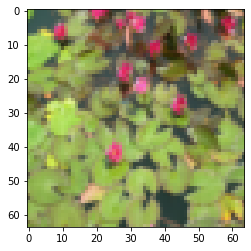

In [7]:
# Example of a picture
index = 18
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [8]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [9]:
# Helper function
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.6950464961800916
Cost after iteration 100: 0.5892596054583806
Cost after iteration 200: 0.5232609173622991
Cost after iteration 300: 0.44976863962219066
Cost after iteration 400: 0.42090021618838985
Cost after iteration 500: 0.3724640306174595
Cost after iteration 600: 0.347420518702019
Cost after iteration 700: 0.31719191987370277
Cost after iteration 800: 0.2664377434774657
Cost after iteration 900: 0.21991432807842576
Cost after iteration 1000: 0.14357898893623774
Cost after iteration 1100: 0.4530921262322089
Cost after iteration 1200: 0.09499357670093518
Cost after iteration 1300: 0.08014128076781374
Cost after iteration 1400: 0.06940234005536468
Cost after iteration 1500: 0.060216640231745944
Cost after iteration 1600: 0.05327415758001881
Cost after iteration 1700: 0.04762903262098436
Cost after iteration 1800: 0.042975888794368707
Cost after iteration 1900: 0.03903607436513822
Cost after iteration 2000: 0.035683136380490275
Cost after iteration 2100: 0.0

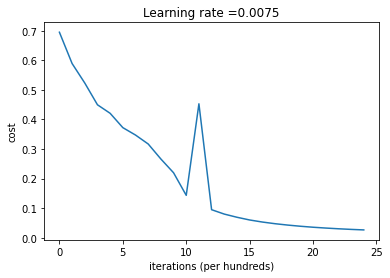

In [10]:
# try 2-layer NN
model = nn_model(layer_sizes=[12288, 7, 1], learning_rate=0.0075, n_epochs=2500)
model.fit(train_x, train_y)
plot_costs(model.costs, model.learning_rate_)

In [11]:
preds = model.predict(train_x)
print(np.sum(preds == train_y) / train_x.shape[1])

1.0


In [12]:
preds = model.predict(test_x)
print(np.sum(preds == test_y) / test_x.shape[1])

0.74


Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822913
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.54013766345478
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766853
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.3917469743480535
Cost after iteration 1000: 0.31518698886006163
Cost after iteration 1100: 0.27269984417893844
Cost after iteration 1200: 0.23741853400268131
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.189263003884633
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.1377748781297294
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.107839285262541

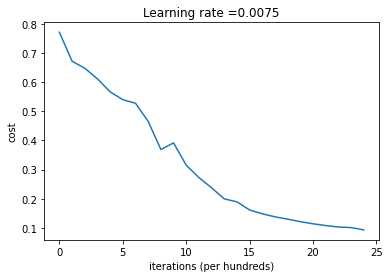

In [13]:
# try deeper model
model = nn_model(layer_sizes=[12288, 20, 7, 5, 1], learning_rate=0.0075, n_epochs=2500)
model.fit(train_x, train_y)
plot_costs(model.costs, model.learning_rate_)

In [14]:
preds = model.predict(train_x)
print(np.sum(preds == train_y) / train_x.shape[1])

0.9856459330143541


In [15]:
preds = model.predict(test_x)
print(np.sum(preds == test_y) / test_x.shape[1])

0.8
